In [1]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, Convolution1D, Flatten, Dense, Dropout, Embedding
from keras.optimizers import Adam
import tensorflow as tf
import nltk 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

c:\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#nltk.download() 

In [3]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
DENSE_LAYER_SIZE =256
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.1
VERBOSE = 1
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [4]:
#Defining model
def define_model(input_size, output_size, verbose = True, dense_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    
  
    inputs = Input(shape = (input_size,1))
    dense1 = Convolution1D(filters = 100, kernel_size = 3, activation=hidden_activation_fn)(inputs)
    flat1 = Flatten()(dense1)

    output = Dense(units=output_size, activation=output_activation_fn)(flat1)
  
    
    # Create model
    model = Model(inputs = [inputs], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = Adam(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model

In [5]:
#Read data
data = pd.read_csv(FILE_NAME)

In [6]:
documents = data[X_LABEL_NAME]
tokenizer = Tokenizer()

In [7]:
tokenizer.fit_on_texts(documents)
vocab_size = len(tokenizer.word_index) + 1

In [8]:
encoded_docs = tokenizer.texts_to_sequences(documents)


In [9]:
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[   26  2954   143 ...     0     0     0]
 [   11    89   125 ...     0     0     0]
 [    7    15   145 ...     0     0     0]
 ...
 [10408  5067 15798 ...     0     0     0]
 [   17    34  4660 ...     0     0     0]
 [   13  1353     6 ...     0     0     0]]


In [10]:
#Defining model
def define_model(input_size, output_size, verbose = True, dense_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    
  
    inputs = Input(shape = (input_size,1))
    emb_lay = Embedding(vocab_size, 100, input_length=max_length)(inputs)
    dense1 = Convolution1D(filters = 100, kernel_size = 3, activation=hidden_activation_fn)(inputs)
    flat1 = Flatten()(dense1)

    output = Dense(units=output_size, activation=output_activation_fn)(flat1)
  
    
    # Create model
    model = Model(inputs = [inputs], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = Adam(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model

In [11]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [12]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [13]:
X_train= tokenizer.texts_to_sequences(text_train)
X_train =  pad_sequences(X_train, maxlen=max_length, padding='post')

In [14]:

X_test= tokenizer.texts_to_sequences(text_test)
X_test =  pad_sequences(X_test, maxlen=max_length, padding='post')

In [15]:

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [16]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [17]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 150)
(3916, 150)
(15663,)
(3916,)


In [18]:
# X_train = X_train[:,None]
# X_test = X_test[:,None]

# X_train = X_train[:None,]
# X_test = X_test[:None,]

In [19]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 150)
(3916, 150)


In [20]:
# X_train = np.reshape(X_train,( -1,23230,1))
# X_test= np.reshape(X_test,( -1,23230,1))

# X_train = np.reshape(X_train,( -1,1,23230))
# X_test= np.reshape(X_test,( -1,1,23230))

In [21]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    cnn_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      dense_layer_size = DENSE_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = cnn_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
294/294 [==============================] - 1s 4ms/step - loss: 118.3034 - accuracy: 0.3888 - val_loss: 1.0902 - val_accuracy: 0.3962
Epoch 2/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0960 - accuracy: 0.3897 - val_loss: 1.0945 - val_accuracy: 0.3962
Epoch 3/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0940 - accuracy: 0.3967 - val_loss: 1.0920 - val_accuracy: 0.3962
Epoch 4/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0932 - accuracy: 0.3946 - val_loss: 1.1151 - val_accuracy: 0.3962
Epoch 5/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0937 - accuracy: 0.3981 - val_loss: 1.0910 - val_accuracy: 0.3962
Epoch 6/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0951 - accuracy: 0.3896 - val_loss: 1.1057 - val_accuracy: 0.3139
Epoch 7/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0950 - accuracy: 0.3899 - val_loss: 1.0909 - val_accuracy: 0.39

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


294/294 [==============================] - 1s 4ms/step - loss: 92.1538 - accuracy: 0.3870 - val_loss: 1.0947 - val_accuracy: 0.3962
Epoch 2/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0927 - accuracy: 0.3924 - val_loss: 1.0964 - val_accuracy: 0.3962
Epoch 3/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0935 - accuracy: 0.3934 - val_loss: 1.1029 - val_accuracy: 0.3139
Epoch 4/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0945 - accuracy: 0.3903 - val_loss: 1.0906 - val_accuracy: 0.3962
Epoch 5/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0932 - accuracy: 0.3888 - val_loss: 1.0953 - val_accuracy: 0.3962
Epoch 6/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0928 - accuracy: 0.3977 - val_loss: 1.1100 - val_accuracy: 0.3139
Epoch 7/10
294/294 [==============================] - 1s 4ms/step - loss: 1.0929 - accuracy: 0.3967 - val_loss: 1.0904 - val_accuracy: 0.3962
Epoch 8/10
294/2

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


294/294 [==============================] - 1s 4ms/step - loss: 142.5940 - accuracy: 0.3920 - val_loss: 1.0901 - val_accuracy: 0.4105
Epoch 2/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0934 - accuracy: 0.3951 - val_loss: 1.0884 - val_accuracy: 0.4105
Epoch 3/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0928 - accuracy: 0.3993 - val_loss: 1.0866 - val_accuracy: 0.4105
Epoch 4/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0916 - accuracy: 0.3964 - val_loss: 1.0895 - val_accuracy: 0.4105
Epoch 5/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0932 - accuracy: 0.3911 - val_loss: 1.0869 - val_accuracy: 0.4105
Epoch 6/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0935 - accuracy: 0.3854 - val_loss: 1.0854 - val_accuracy: 0.4105
Epoch 7/10
294/294 [==============================] - 1s 3ms/step - loss: 1.0927 - accuracy: 0.3987 - val_loss: 1.0866 - val_accuracy: 0.4105
Epoch 8/10
294/

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.3755532856656452
Average Precision across K-folds: 0.14328981474429137
Average Recall across K-folds: 0.3755532856656452
Average F1 Score across K-folds: 0.20684091865738818
Average Training Time across K-folds: 10.31300139427185 seconds
Prediction Time across K-folds: 0.26799917221069336 seconds


In [23]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


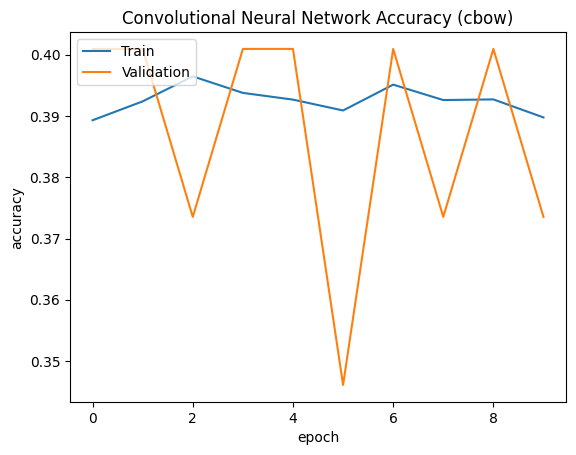

In [24]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Convolutional Neural Network Accuracy (cbow)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network_cbow_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


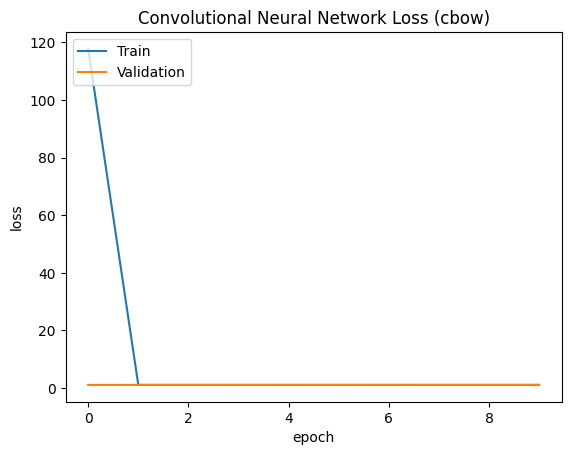

In [25]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Convolutional Neural Network Loss (cbow)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network__cbow_loss.eps", format='eps')
plt.show()